In [1]:
import math
import matplotlib.pyplot as plt
import pickle as pkl

%matplotlib inline

## 3.1 决策树的构造

In [2]:
def calc_entropy(dataset):   # 计算信息熵
    num_entries = len(dataset)
    label_counts = {}
    for feature_vec in dataset:
        cur_label = feature_vec[-1]
        label_counts[cur_label] = label_counts.get(cur_label, 0) + 1
    entropy = 0.0
    for _, value in label_counts.items():
        prob = 1.0 * value / num_entries
        entropy -= prob * math.log(prob, 2)
    return entropy

In [3]:
def create_dataset():
    dataset = [[1, 1, 'yes'],
               [1, 1, 'yes'],
               [1, 0, 'no'],
               [0, 1, 'no'],
               [0, 1, 'no']]
    labels = ['no surfacing', 'flippers']
    return dataset, labels

In [4]:
def split_dataset(dataset, axis, value):   # 划分数据集
    ret_dataset = []
    for feature_vec in dataset:
        if feature_vec[axis] == value:
            reduce_vec = feature_vec[:axis]
            reduce_vec.extend(feature_vec[axis+1:])
            ret_dataset.append(reduce_vec)
    return ret_dataset

In [5]:
def choose_best_feature(dataset):
    num_features = len(dataset[0]) - 1 # 最后一排是标签
    best_entropy = calc_entropy(dataset)
    best_info_gain = 0.0
    best_feature = -1
    for i in range(num_features):
        feature_list = [example[i] for example in dataset]  # 取一列
        unique_feature = set(feature_list)
        new_entropy = 0.0
        for val in unique_feature:  # 每种划分的信息熵
            sub_dataset = split_dataset(dataset, i, val)
            prob = len(sub_dataset) / len(dataset)
            new_entropy += prob * calc_entropy(sub_dataset)
        info_gain = best_entropy - new_entropy
        if info_gain > best_info_gain:
            best_info_gain = info_gain
            best_feature = i
    return best_feature

In [6]:
def majority_cnt(class_list):    # 计算最多分类
    class_count = {}
    for vote in class_list:
        class_count[vote] = class_count.get(vote, 0) + 1
    sorted_class_count = sorted(class_count.items(), key=lambda x : x[1], reverse=True)
    return sorted_class_count[0][0]

In [7]:
def create_tree(dataset, labels):
    class_list = [example[-1] for example in dataset]
    if class_list.count(class_list[0]) == len(class_list):  # 类别完全相同停止划分
        return class_list[0]
    if len(dataset[0]) == 1:
        return majority_cnt(class_list)    # 没有特征可再划分
    best_feature = choose_best_feature(dataset)
    best_feature_label = labels[best_feature]
    myTree = {best_feature_label: {}}
    sub_labels = labels[:best_feature] + labels[best_feature+1:]
    feature_vals = [example[best_feature] for example in dataset]   # 根据特征列进行划分
    unique_vals = set(feature_vals)
    for value in unique_vals:
        myTree[best_feature_label][value] = create_tree(split_dataset(dataset, best_feature, value), sub_labels)
    return myTree

In [8]:
mydata, labels = create_dataset()

In [9]:
myTree = create_tree(mydata, labels)

In [10]:
myTree

{'no surfacing': {0: 'no', 1: {'flippers': {0: 'no', 1: 'yes'}}}}

## 3.2 在Python中使用Matplotlib注解绘制树形图

In [11]:
decision_node = dict(boxstyle='sawtooth', fc='0.8')
leaf_node = dict(boxstyle='round4', fc='0.8')
arrow_args = dict(arrowstyle="<-")

def plot_node(node_text, center_pt, parent_pt, node_type):
    create_plot.ax1.annotate(node_text, 
                             xy=parent_pt, 
                             xycoords='axes fraction', 
                             xytext=center_pt, 
                             textcoords='axes fraction',
                             va='center',
                             ha='center',
                             bbox=node_type,
                             arrowprops=arrow_args)

In [12]:
def create_plot():
    fig = plt.figure(1, facecolor='white', figsize=(7, 6))
    fig.clf()
    create_plot.ax1 = plt.subplot(111, frameon=False)
    plot_node('a decision node', (0.5, 0.1), (0.1, 0.5), decision_node)
    plot_node('a leaf node', (0.8, 0.1), (0.3, 0.8), leaf_node)
    plt.show()

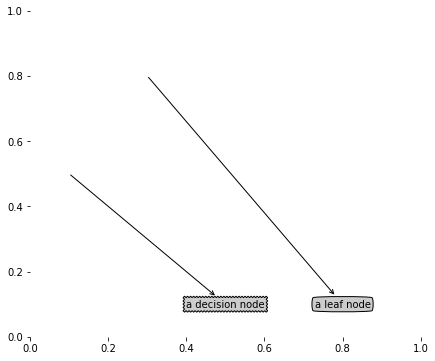

In [13]:
create_plot()

In [14]:
def get_num_leafs(myTree):
    num_leafs = 0
    first_str = list(myTree.keys())[0]
    second_dict = myTree[first_str]
    for key in second_dict.keys():
        if type(second_dict[key]).__name__ == 'dict':
            num_leafs += get_num_leafs(second_dict[key])
        else:
            num_leafs += 1
    return num_leafs

def get_tree_depth(myTree):
    max_depth = 0
    first_str = list(myTree.keys())[0]
    second_dict = myTree[first_str]
    for key in second_dict.keys():
        if type(second_dict[key]).__name__ == 'dict':
            this_depth = 1 + get_tree_depth(second_dict[key])
        else:
            this_depth = 1
        if this_depth > max_depth:
            max_depth = this_depth
    return max_depth

In [15]:
def retrieveTree(i):
    list_of_trees = [{'no surfacing': {0: 'no', 1: {'flippers': {0: 'no', 1: 'yes'}}}},
                     {'no surfacing': {0: 'no', 1: {'flippers': {0 : {'head': {0: 'no', 1: 'yes'}}, 1: 'no'}}}}
                    ]
    return list_of_trees[i]

In [16]:
def plot_mid_text(cntr_pt, parent_pt, txt_string):
    x_mid = (parent_pt[0] - cntr_pt[0]) / 2.0 + cntr_pt[0]
    y_mid = (parent_pt[1] - cntr_pt[1]) / 2.0 + cntr_pt[1]
    create_plot.ax1.text(x_mid, y_mid, txt_string)

def plot_tree(myTree, parent_pt, node_text):
    num_leafs = get_num_leafs(myTree)
    depth = get_tree_depth(myTree)
    first_str = list(myTree.keys())[0]
    cntr_pt = (plot_tree.xOff + (1.0 + float(num_leafs)) / 2.0 / plot_tree.totalW, plot_tree.yOff)
    plot_mid_text(cntr_pt, parent_pt, node_text)
    plot_node(first_str, cntr_pt, parent_pt, decision_node)
    second_dict = myTree[first_str]
    plot_tree.yOff = plot_tree.yOff - 1.0/plot_tree.totalD
    for key in second_dict.keys():
        if type(second_dict[key]).__name__=='dict':
            plot_tree(second_dict[key],cntr_pt,str(key))        #recursion
        else:   #it's a leaf node print the leaf node
            plot_tree.xOff = plot_tree.xOff + 1.0/plot_tree.totalW
            plot_node(second_dict[key], (plot_tree.xOff, plot_tree.yOff), cntr_pt, leaf_node)
            plot_mid_text((plot_tree.xOff, plot_tree.yOff), cntr_pt, str(key))
    plot_tree.yOff = plot_tree.yOff + 1.0/plot_tree.totalD

In [17]:
def create_plot(inTree):
    fig = plt.figure(1, facecolor='white', figsize=(14, 12))
    fig.clf()
    axprops = dict(xticks=[], yticks=[])
    create_plot.ax1 = plt.subplot(111, frameon=False, **axprops)    #no ticks
    #createPlot.ax1 = plt.subplot(111, frameon=False) #ticks for demo puropses 
    plot_tree.totalW = float(get_num_leafs(inTree))
    plot_tree.totalD = float(get_tree_depth(inTree))
    plot_tree.xOff = -0.5/plot_tree.totalW; plot_tree.yOff = 1.0;
    plot_tree(inTree, (0.5,1.0), '')
    plt.show()

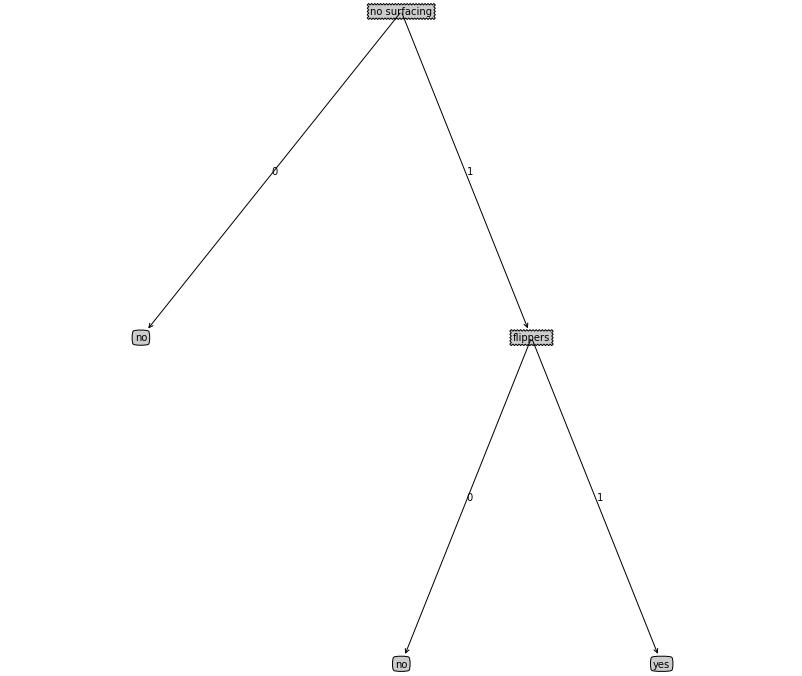

In [18]:
create_plot(myTree)

## 3.3 测试和存储分类器

In [19]:
def classify(input_tree, feat_labels, testvec):
    first_str = list(input_tree.keys())[0]
    second_dict = input_tree[first_str]
    feat_index = feat_labels.index(first_str)
    for key in second_dict.keys():
        if testvec[feat_index] == key:
            if type(second_dict[key]).__name__ == 'dict':
                class_label = classify(second_dict[key], feat_labels, testvec)
            else:
                class_label = second_dict[key]
    return class_label

In [20]:
myDat, labels = create_dataset()
myTree = retrieveTree(0)
myTree

{'no surfacing': {0: 'no', 1: {'flippers': {0: 'no', 1: 'yes'}}}}

In [21]:
classify(myTree, labels, [1, 0])

'no'

In [22]:
classify(myTree, labels, [1, 1])

'yes'

In [23]:
def store_tree(input_tree, filename):
    fw = open(filename, 'wb')
    pkl.dump(input_tree, fw)
    fw.close()

def grab_tree(filename):
    fr = open(filename, 'rb')
    return pkl.load(fr)

In [24]:
store_tree(myTree, 'classifierStorage.txt')

In [25]:
grab_tree('classifierStorage.txt')

{'no surfacing': {0: 'no', 1: {'flippers': {0: 'no', 1: 'yes'}}}}

## 3.4 示例：使用决策树预测隐形眼镜类型

In [26]:
def read_lense_data(filename):
    fr = open(filename, 'r')
    lenses = [inst.strip().split('\t') for inst in fr.readlines()]
    lense_labels = ['age', 'prescript', 'astigmatic', 'teatRate']
    return lenses, lense_labels

In [27]:
lenses, lense_labels = read_lense_data('lenses.txt')
lenses_tree = create_tree(lenses, lense_labels)
lenses_tree

{'teatRate': {'normal': {'astigmatic': {'no': {'age': {'pre': 'soft',
      'presbyopic': {'prescript': {'hyper': 'soft', 'myope': 'no lenses'}},
      'young': 'soft'}},
    'yes': {'prescript': {'hyper': {'age': {'pre': 'no lenses',
        'presbyopic': 'no lenses',
        'young': 'hard'}},
      'myope': 'hard'}}}},
  'reduced': 'no lenses'}}

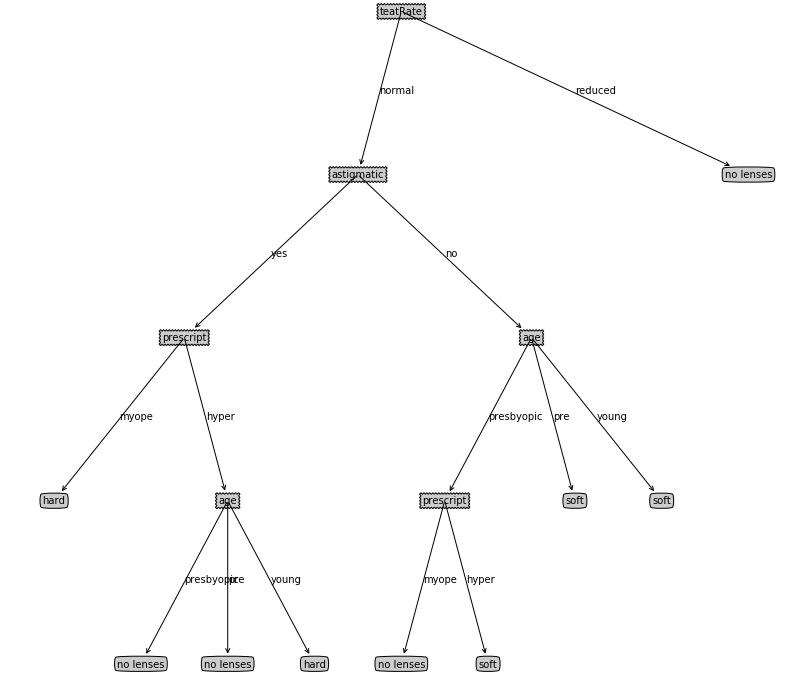

In [28]:
create_plot(lenses_tree)